# PyTorch Data Pipeline Notes
Short, practical notes I wrote while working through `Datasets` and `DataLoader` examples. Kept simple so I can revisit quickly.

## Why separate data code
Keeping dataset loading and preprocessing out of the training loop makes the code easier to read and debug. `Dataset` gives single-sample access; `DataLoader` handles batching, shuffling, and parallel loading.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchvision.io import decode_image

## Loading FashionMNIST (quick)
I used the torchvision helper to pull down Fashion-MNIST. This is handy for quick experiments and visual checks.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.6MB/s]


## Quick visualization
I usually plot a small grid to sanity-check labels and look for obvious issues in the data.

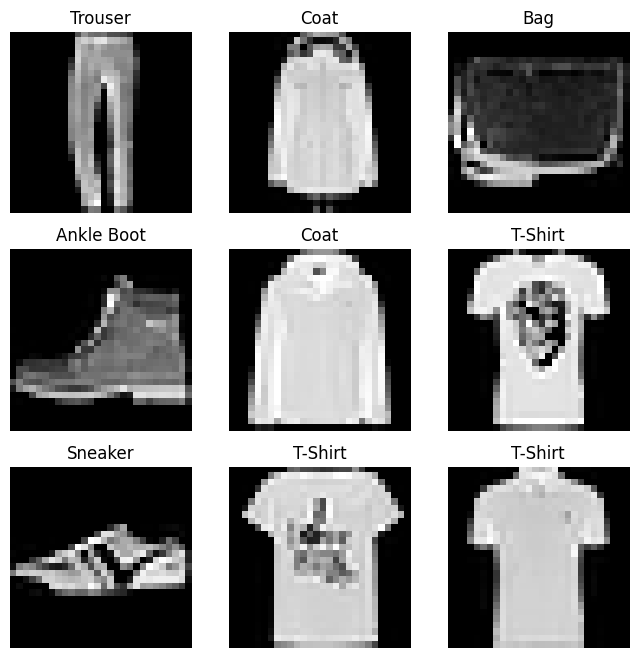

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Custom Dataset: my version
I keep a tiny class that reads a CSV of filenames + labels and returns tensors. This is what I typically use for small image projects.

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Notes on the methods:
- `__init__`: read CSV and keep transforms
- `__len__`: returns number of rows in CSV
- `__getitem__`: decode image, apply transforms, return (image, label)

## DataLoader: how I use it
Batching and shuffling are the main reasons to use `DataLoader`. For training I set `shuffle=True` and a reasonable `batch_size` (e.g., 64). I also set `num_workers` depending on the machine.

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## Inspecting a batch
I grab the first batch to check shapes and that the pipeline returns the expected tensors.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


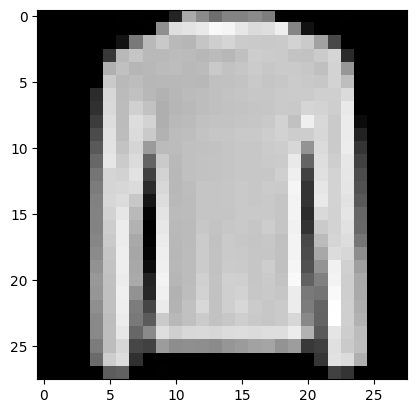

Label: 2


In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Quick reminders
- Use `shuffle=True` for training.
- Use transforms to normalize / augment.
- Watch `num_workers` on different OSes (0 for debugging).
- Keep dataset code minimal and well-tested so training scripts stay clean.